# Noise2Noise : Apprendre la restitution d'images sans données propres - Application avec une architecture ResNet

### Connection drive

Dans un premier temps, connectez-vous au drive pour accéder au dataset :

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importation des librairies pytorch

In [2]:
import torch
from torch import optim
from torch import Tensor
from torch import nn
from torch.nn import functional as F


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Importation des données

Téléchargement de nos données provenant du dataset [Kaggle](https://www.kaggle.com/datasets/mehrdadkianiosh/noisy-images?resource=download). 

Le dataset est composé de deux fichiers : un fichier `train_data.pkl` contenant 50000 paires d'images bruitées et un fichier `val_data.pkl` contenant 1000 paires d'images bruitées.

Le dataset provient d'un challenge Kaggle, il n'y a donc pas de `test set` disponible. Nous testerons directement notre modèle sur le `validation set`.

Nous utilisons ici le fichier `augmented_train_data.pkl` que nous avons généré grâce au au jupyter notebook `Data_augmentation.ipynb`. Il contient 150000 paires d'images bruitées, soit les 50000 paires d'images bruitées du fichier `train_data.pkl` et 100000 paires d'images bruitées qui sont des flips horizontaux et verticaux 180° des 50000 paires d'images initiales.


In [4]:
# import data
noisy_imgs_1 , noisy_imgs_2 = torch.load('/content/drive/MyDrive/DeepL_Project/dataset/augmented_train_data.pkl')
noisy_imgs , clean_imgs = torch.load('/content/drive/MyDrive/DeepL_Project/dataset/val_data.pkl')

print(noisy_imgs_1.shape)
print(noisy_imgs.shape)

# normalized data between 0 and 1 (because some torch function are optimized for inputs between 0 & 1)
# noisy_imgs_1 = noisy_imgs_1/255 (we don't normalized here the images from the augmented_train_data.pkl file because it has already been normalized during Data_augmentation)
# noisy_imgs_2 = noisy_imgs_2/255
noisy_imgs = noisy_imgs/255
clean_imgs = clean_imgs/255

torch.Size([150000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])


**Visualisation de notre dataset**

Importez la librairie matplotlib pour visualiser nos données :

In [5]:
from matplotlib import pyplot as plt

Utilisation de `torch.permute` pour avoir une vue du tenseur d'origine :



Text(0.5, 1.0, 'Example of a clean_imgs from the validation set')

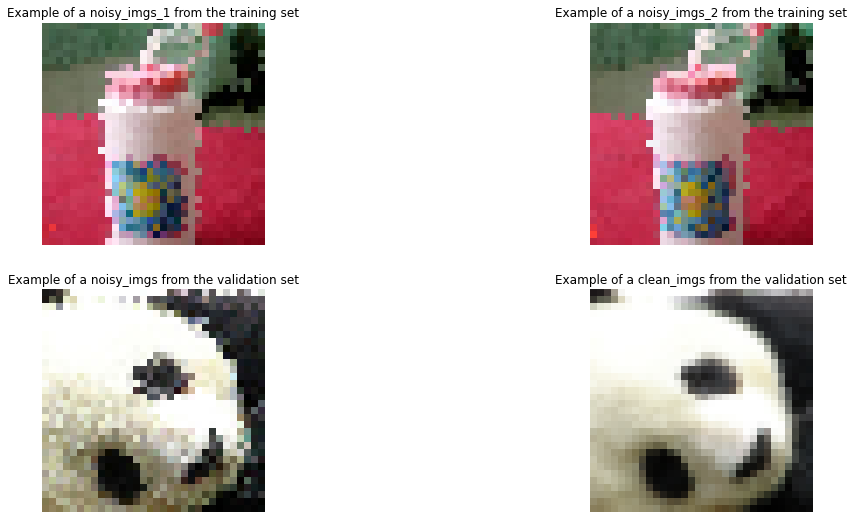

In [6]:
# create figure
fig = plt.figure(figsize=(18, 9))
    
# setting values to rows and column variables
rows = 2
columns = 2

# adds a subplot
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(noisy_imgs_1[7].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs_1 from the training set")

# adds a subplot
fig.add_subplot(rows, columns, 2)
    
# showing image
plt.imshow(noisy_imgs_2[7].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs_2 from the training set")
      
# adds a subplot 
fig.add_subplot(rows, columns, 3)
      
# showing image
plt.imshow(noisy_imgs[13].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs from the validation set")

# adds a subplot 
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(clean_imgs[13].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a clean_imgs from the validation set")

### Calcul du PSNR avant entraînement de notre modèle

Pour évaluer nos modèles, nous utiliserons la mesure du **PSNR**, exprimée en décibel (dB).

Le PSNR permet de quantifier la performance des modèles en mesurant la qualité de reconstruction de l'image compressée par rapport à l'image originale.

Pour pouvoir étudier si notre modèle est performant, nous pouvons comparer le PSNR du validation set qui calculera le PSNR entre notre `image bruitée` et notre `clean image`, avec le PSNR après entraînement du modèle qui calculera le PSNR entre notre `predicted image` et notre `clean image`.

En conséquence, si nous obtenons un PSNR plus élevé après notre modèle, cela signifie que notre signal et donc le traitement de restauration ou d'amélioration sont meilleurs. 

In [7]:
def psnr(denoised , ground_truth):
# Peak Signal to Noise Ratio : denoised and ground_truth have values between 0 and 1
  mse = torch.mean((denoised - ground_truth) ** 2)
  return -10 * torch.log10(mse + 10**-8)

sum = 0
nb_img = noisy_imgs.size(0)
psnr_list = []

for i in range(nb_img):
  psnr_list.append(psnr(noisy_imgs[i].cpu(), clean_imgs[i].cpu()).item())
    
for j in range(nb_img):
  sum = sum + psnr_list[j]

mean_psnr = sum/nb_img

print("PSNR mean : " + str(mean_psnr) + " dB")

PSNR mean : 20.723881640434264 dB


Nous obtenons un PSNR moyen de 20.72 dB pour notre validation set. Implémentons notre modèle et comparons notre PNSR final à celui-ci.

## Architecture ResNet

Nous implémentons une structure similaire au ResNet :

In [8]:
# network architecture
class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        pass
        
        self.conv3_32 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv32_32_1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv32_32_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv32_64_x = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv64_96_x = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.conv64_96_y = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.conv96_96_1 = nn.Conv2d(96, 96, kernel_size=3, padding=1)
        self.conv96_64_x = nn.Conv2d(96, 64, kernel_size=3, padding=1)
        self.conv96_64_y = nn.Conv2d(96, 64, kernel_size=3, padding=1)
        self.conv64_32 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.t_conv32_3 = nn.ConvTranspose2d(32, 3, kernel_size=1, stride=1)
        self.bn32_1 = nn.BatchNorm2d(32)
        self.bn32_2 = nn.BatchNorm2d(32)
        self.bn96 = nn.BatchNorm2d(96)
        self.bn96_y = nn.BatchNorm2d(96)
        
    
    def forward(self, x):
        x0 = x
        x = F.relu(self.conv3_32(x))
        x = F.relu(self.conv32_32_1(x))
        x = self.bn32_1(x)
        x = F.relu(self.conv32_64_x(x))
        y = F.relu(self.conv64_96_y(x))
        y = F.relu(self.conv96_96_1(y))
        y = self.bn96_y(y)
        y = F.relu(self.conv96_64_y(y))
        x = x+y
        x = F.relu(self.conv64_96_x(x))
        x = self.bn96(x)
        x = F.relu(self.conv96_64_x(x))
        x = F.relu(self.conv64_32(x))
        x = self.bn32_2(x)
        x = F.relu(self.conv32_32_2(x))
        x = self.t_conv32_3(x)
        x = F.relu(x)
        x = torch.clamp(x, min=0, max=1)
        return x

In [9]:
class Model(nn.Module):
    def __init__(self) -> None:
        # instantiation of the model, loss function and optimizer
        super().__init__()
        self.autoencoder = Network().to(device)
        self.criterion = nn.MSELoss().to(device)
        self.optimizer = torch.optim.Adam(self.autoencoder.parameters(), lr = 1e-3)
        self.weight_initialization()
        pass

    def weight_initialization(self):
        for mod in self.modules():
          if isinstance(mod, nn.Conv2d):
            nn.init.kaiming_normal_(mod.weight.data)
            mod.bias.data.zero_()

    def load_last_trained_model(self) :
    # to load the parameters saved in parameters_models_ResNet.pth into the model
    # self.load_state_dict(torch.load(path, map_location=torch.device(device)))        
        saved_model_path = "/content/drive/MyDrive/DeepL_Project/parameters_models_ResNet.pth"
        model = torch.load(saved_model_path)
        self.load_state_dict(model)
        self.to(device)
        pass
  
    def save_parameters_Model(self) :
        # to save our parameters in parameters_models.pth
        torch.save(self.state_dict(), '/content/drive/MyDrive/DeepL_Project/parameters_models_ResNet.pth')
        pass 

    def train(self, train_imgs_1, train_imgs_2, nb_epochs) -> None:
        # train_imgs_1 : tensor of size (N, C, H, W) with a noisy version of the images     
        # train_imgs_2 : tensor of size (N, C, H, W) with another noisy version of the same images, which only differs from the input by their noise
        mini_batch_size = 100
        loss_list = []

        for e in range(nb_epochs):
            acc_loss = 0
            for b in range(0, train_imgs_1.size(0), mini_batch_size):
                output = self.autoencoder(train_imgs_1.narrow(0, b, mini_batch_size).to(device))
                loss = self.criterion(output, train_imgs_2.narrow(0, b, mini_batch_size).to(device))
                acc_loss = acc_loss + loss.item()
                # self.autoencoder.zero_grad()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(e, acc_loss)

            print("Loss : ", loss.item())
            loss_list.append(loss.item())
        return loss_list
        pass

    def prediction(self, val_input) -> torch.Tensor:
        # val_input : tensor of size (N1, C, H, W) that has to be denoised by the trained network
        # returns a tensor of the size (N1, C, H, W)
        return self.autoencoder(val_input)
        pass

torch.cuda.empty_cache()

**Entraînement de notre modèle**

Installez la librairie `ipython-autotime` afin de pouvoir indiquer le temps d'exécution de notre modèle :

In [10]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00
time: 544 µs (started: 2023-03-02 13:26:48 +00:00)


In [11]:
m = Model()

time: 4.07 s (started: 2023-03-02 13:26:48 +00:00)


Téléchargez le dernier train modèle sauvegardé afin de ne pas réexécuter le modèle :

In [20]:
m.load_last_trained_model()

time: 16.1 ms (started: 2023-03-02 13:36:16 +00:00)




---



*Les deux cellules suivantes sont à exécuter uniquement si vous voulez entraîner d'autres architectures de réseaux.*

Exécuter la cellule uniquement si vous voulez entraîné un nouveau réseau :

In [12]:
loss_list = m.train(noisy_imgs_1.float(), noisy_imgs_2.float(), nb_epochs = 20)

0 29.244520351290703
Loss :  0.01650424674153328
1 23.809029596857727
Loss :  0.016218822449445724
2 23.196656215935946
Loss :  0.01598775014281273
3 22.899531798437238
Loss :  0.016014980152249336
4 22.987446807324886
Loss :  0.01586087793111801
5 22.627502783201635
Loss :  0.01594359241425991
6 22.6964528625831
Loss :  0.01604263111948967
7 22.857819301076233
Loss :  0.015844250097870827
8 22.667389719747007
Loss :  0.015847770497202873
9 22.40473479218781
Loss :  0.015766778960824013
10 22.26858072541654
Loss :  0.015681849792599678
11 22.20531967189163
Loss :  0.015671996399760246
12 22.078426306135952
Loss :  0.015624983236193657
13 22.049024344421923
Loss :  0.015654532238841057
14 21.965354553423822
Loss :  0.015683015808463097
15 22.005519615486264
Loss :  0.01575297862291336
16 21.89592903573066
Loss :  0.015584801323711872
17 22.190412627533078
Loss :  0.01572098210453987
18 21.86284775007516
Loss :  0.015647130087018013
19 21.810953732579947
Loss :  0.015585930086672306
time

Le fichier `parameters_models_ResNet.pth` permet de sauvegarder les paramètres du training pour garder en mémoire les performances des différentes architectures réseaux (pas besoin de relancer de training pour une architecture qui a déjà été lancée !). Dans le fichier `parameters_models_ResNet.pth` se trouve uniquement les paramètres de notre modèle sélectionné. Si vous voulez entraîner d'autres réseaux et les sauvegarder dans le fichier, exécutez la cellule suivante :

In [13]:
m.save_parameters_Model()

time: 22.2 ms (started: 2023-03-02 13:32:35 +00:00)


**Visualition de la `loss function` en fonction du nombre d'epochs**

Importez la libraire numpy :

In [14]:
import numpy as np

time: 510 µs (started: 2023-03-02 13:32:35 +00:00)


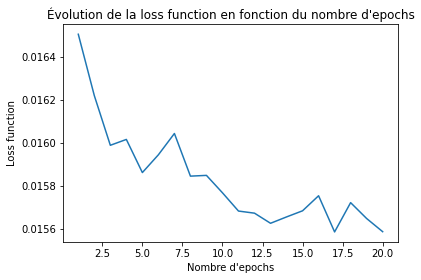

time: 197 ms (started: 2023-03-02 13:32:35 +00:00)


In [15]:
# create a numpy array manually to have our number of epochs
epochs = np.arange(1,21)

# create figure
plt.plot(epochs,loss_list)

# add titles
plt.title("Évolution de la loss function en fonction du nombre d'epochs")
plt.xlabel("Nombre d'epochs")
plt.ylabel('Loss function')

# showing figure
plt.show()

Nous observons que notre `loss function` décroît bien en fonction du nombre d'epochs.

**Déclaration et visualation de notre `predicted image`** 

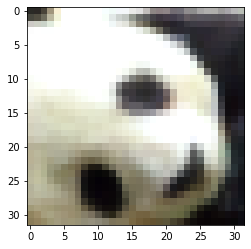

time: 195 ms (started: 2023-03-02 13:32:35 +00:00)


In [16]:
predicted_img = m.prediction(noisy_imgs.float().to(device))

with torch.no_grad():
  plt.imshow(predicted_img[13].cpu().permute(1,2,0))

### Visualisation finale des données du `validation set`

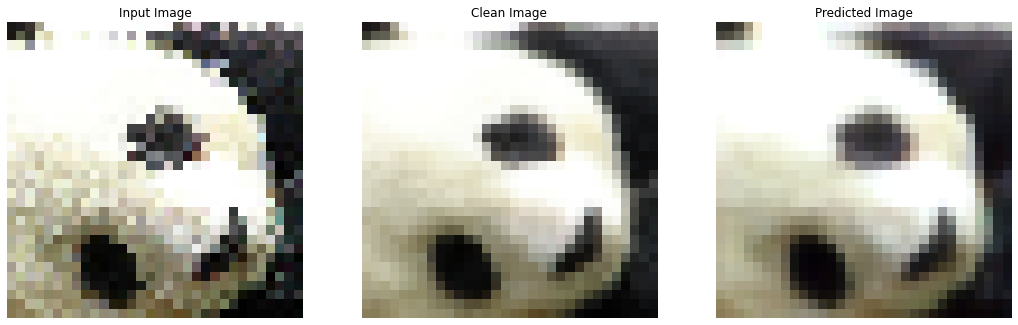

time: 201 ms (started: 2023-03-02 13:32:35 +00:00)


In [17]:
with torch.no_grad():

  # create figure
  fig = plt.figure(figsize=(18, 9))
    
  # setting values to rows and column variables
  rows = 1
  columns = 3

  # adds a subplot 
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(noisy_imgs[13].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Input Image")

  # adds a subplot 
  fig.add_subplot(rows, columns, 2)
    
  # showing image
  plt.imshow(clean_imgs[13].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Clean Image")
      
  # adds a subplot 
  fig.add_subplot(rows, columns, 3)
      
  # showing image
  plt.imshow(predicted_img[13].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Predicted Image")

Nous remarquons que notre `predicted image` est très proche visuellement de la `clean image`.

Il est important de souligner que notre jeu de données est en base résolution pour permettre de réduire les temps de calculs pouvant être trop volumineux en haute réoslution. Notre `clean image` et `predicted image` restent donc floues à l'oeil nu.

### Calcul du PSNR après entraînement de notre modèle

In [18]:
def psnr(denoised , ground_truth):
# Peak Signal to Noise Ratio: denoised and grounḋ_truth have values between 0 and 1
  mse = torch.mean((denoised - ground_truth) ** 2)
  return -10 * torch.log10(mse + 10**-8)

sum = 0
nb_img = predicted_img.size(0)
psnr_list = []

for i in range(nb_img):
  psnr_list.append(psnr(predicted_img[i].cpu(), clean_imgs[i].cpu()).item())
    
for j in range(nb_img):
  sum = sum + psnr_list[j]

mean_psnr = sum/nb_img

print("PSNR mean : " + str(mean_psnr) + " dB")

PSNR mean : 25.427729473114013 dB
time: 106 ms (started: 2023-03-02 13:32:35 +00:00)


Nous obtenons un PSNR moyen de 25.43 dB après l'entraînement de notre ResNet avec data augmentation et 25.21 sans data augmentation avec le fichier `train_data.pkl`.

En conséquence, nous obtenons un PSNR plus élevé après entraînement de notre modèle, cela signifie que notre signal et donc le traitement de restauration ou d'amélioration sont meilleurs. Néanmoins, il reste moins bon que le modèle U-Net.